In [47]:
import sys
sys.path.append("../../../")

import os 
os.environ["WANDB_API_KEY"] = "d63df136f169bffa17486544a5339caee2aec09c"

from modules.acquire_data import DataAcquire
from modules.analyze_data import analyze_data
from modules.create_model import create_model

da = DataAcquire()

In [109]:
df_train = da.get_data_and_columns("Train")
df_test = da.get_data_and_columns("Test")

DATA ACQUIRE:COMPLETE

COLUMNS
----------------------------------------
COLUMN :  D-TYPE :  #NANS
id : int64 : 0 nans
Podcast_Name : object : 0 nans
Episode_Title : object : 0 nans
Episode_Length_minutes : float64 : 87093 nans
Genre : object : 0 nans
Host_Popularity_percentage : float64 : 0 nans
Publication_Day : object : 0 nans
Publication_Time : object : 0 nans
Guest_Popularity_percentage : float64 : 146030 nans
Number_of_Ads : float64 : 1 nans
Episode_Sentiment : object : 0 nans
Listening_Time_minutes : float64 : 0 nans

DATA ACQUIRE:COMPLETE

COLUMNS
----------------------------------------
COLUMN :  D-TYPE :  #NANS
id : int64 : 0 nans
Podcast_Name : object : 0 nans
Episode_Title : object : 0 nans
Episode_Length_minutes : float64 : 28736 nans
Genre : object : 0 nans
Host_Popularity_percentage : float64 : 0 nans
Publication_Day : object : 0 nans
Publication_Time : object : 0 nans
Guest_Popularity_percentage : float64 : 48832 nans
Number_of_Ads : float64 : 0 nans
Episode_Sentiment : 

In [110]:
df_train

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


In [121]:
import os
import random
import numpy as np
import pandas as pd
import wandb

from wandb.integration.lightgbm import log_summary, wandb_callback

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [145]:
df_train = da.get_data_and_columns("Train")
df_test = da.get_data_and_columns("Test")

DATA ACQUIRE:COMPLETE

COLUMNS
----------------------------------------
COLUMN :  D-TYPE :  #NANS
id : int64 : 0 nans
Podcast_Name : object : 0 nans
Episode_Title : object : 0 nans
Episode_Length_minutes : float64 : 87093 nans
Genre : object : 0 nans
Host_Popularity_percentage : float64 : 0 nans
Publication_Day : object : 0 nans
Publication_Time : object : 0 nans
Guest_Popularity_percentage : float64 : 146030 nans
Number_of_Ads : float64 : 1 nans
Episode_Sentiment : object : 0 nans
Listening_Time_minutes : float64 : 0 nans

DATA ACQUIRE:COMPLETE

COLUMNS
----------------------------------------
COLUMN :  D-TYPE :  #NANS
id : int64 : 0 nans
Podcast_Name : object : 0 nans
Episode_Title : object : 0 nans
Episode_Length_minutes : float64 : 28736 nans
Genre : object : 0 nans
Host_Popularity_percentage : float64 : 0 nans
Publication_Day : object : 0 nans
Publication_Time : object : 0 nans
Guest_Popularity_percentage : float64 : 48832 nans
Number_of_Ads : float64 : 0 nans
Episode_Sentiment : 

## カテゴリ変数の特徴量エンジニアリング

In [146]:
#　　Genre, Episode_Sentimentはワンホットエンコーディング
# Podcast_Name, Episode_Titleはターゲットエンコーディング

label_encoders = {}

# Podcast_Nameのターゲットエンコーディング
def target_encode_kfold(train_df, 
                        test_df, 
                        target_col, 
                        cat_col, 
                        n_splits=5, 
                        seed=42):
    """
    高カーディナリティカテゴリ列に対してターゲットエンコーディングを行う（KFold方式）

    Parameters:
    - train_df: 学習用DataFrame
    - test_df: テスト用DataFrame
    - target_col: 目的変数の列名
    - cat_col: ターゲットエンコーディングしたいカテゴリ列
    - n_splits: KFold分割数
    - seed: ランダムシード

    Returns:
    - train_df, test_df: TE列が追加されたDataFrame（cat_col+'_te' という列名）
    """
    global_mean = train_df[target_col].mean()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    te_train = np.zeros(len(train_df))
    te_test = np.zeros(len(test_df))

    for train_idx, val_idx in kf.split(train_df):
        X_train, X_val = train_df.iloc[train_idx], train_df.iloc[val_idx]
        means = X_train.groupby(cat_col)[target_col].mean()
        te_train[val_idx] = X_val[cat_col].map(means).fillna(global_mean)

    # テストデータにも全体平均でマッピング
    full_means = train_df.groupby(cat_col)[target_col].mean()
    te_test = test_df[cat_col].map(full_means).fillna(global_mean)

    # 新しい列を追加
    train_df[f"{cat_col}_te"] = te_train
    test_df[f"{cat_col}_te"] = te_test

    train_df.drop(cat_col, axis=1, inplace=True)
    test_df.drop(cat_col, axis=1, inplace=True)
    return train_df, test_df

cat_col = "Podcast_Name"
target_col = "Listening_Time_minutes"
df_train, df_test = target_encode_kfold(df_train, df_test, target_col, cat_col, n_splits=5, seed=42)

In [147]:
# Genre, Episode_Sentimentのワンホットエンコーディング

# ワンホット対象
onehot_cols = ["Genre", "Episode_Sentiment"]

# ワンホットエンコーディング
df_train = pd.get_dummies(df_train, columns=onehot_cols)
df_test = pd.get_dummies(df_test, columns=onehot_cols)

# 列が一致していない場合に備えて再整列
df_train, df_test = df_train.align(df_test, join='left', axis=1, fill_value=0)

In [148]:
# Publication_Day, Publication_Timeの順序付きターゲットエンコーディング

def ordered_target_encode(train_df, test_df, target_col, cat_col):
    """
    ターゲット値に基づく順序付きターゲットエンコーディング。
    """
    # 各カテゴリの平均ターゲット値を取得
    ordering = train_df.groupby(cat_col)[target_col].mean().sort_values().index

    # 辞書に変換（昇順に番号を振る）
    ordered_dict = {cat: i for i, cat in enumerate(ordering)}

    # 数値化
    train_df[f"{cat_col}_ordered_te"] = train_df[cat_col].map(ordered_dict)
    test_df[f"{cat_col}_ordered_te"] = test_df[cat_col].map(ordered_dict).fillna(-1)  # 未知カテゴリは -1 など

    train_df.drop(cat_col, axis=1, inplace=True)
    test_df.drop(cat_col, axis=1, inplace=True)
    return train_df, test_df

ordered_columns = ["Publication_Day", "Publication_Time"]
for col in ordered_columns:
    df_train, df_test = ordered_target_encode(df_train, df_test, "Listening_Time_minutes", col)

In [149]:
df_train

,id,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Podcast_Name_te,Genre_Business,Genre_Comedy,...,Genre_Music,Genre_News,Genre_Sports,Genre_Technology,Genre_True Crime,Episode_Sentiment_Negative,Episode_Sentiment_Neutral,Episode_Sentiment_Positive,Publication_Day_ordered_te,Publication_Time_ordered_te
0,0,Episode 98,NaN,74.81,NaN,0.0,31.41998,45.916516,False,False,...,False,False,False,False,True,False,False,True,1,3
1,1,Episode 26,119.80,66.95,75.95,2.0,88.01241,42.558974,False,True,...,False,False,False,False,False,True,False,False,3,2
2,2,Episode 16,73.90,69.97,8.97,0.0,44.92531,46.942467,False,False,...,False,False,False,False,False,True,False,False,6,0
3,3,Episode 45,67.17,57.22,78.70,2.0,46.27824,44.771390,False,False,...,False,False,False,True,False,False,False,True,5,1
4,4,Episode 86,110.51,80.07,58.68,3.0,75.61031,46.925494,False,False,...,False,False,False,False,False,False,True,False,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Episode 25,75.66,69.36,NaN,0.0,56.87058,45.508378,False,False,...,False,False,False,False,False,True,False,False,3,1
749996,749996,Episode 21,75.75,35.21,NaN,2.0,45.46242,47.131934,True,False,...,False,False,False,False,False,False,True,False,3,3
749997,749997,Episode 51,30.98,78.58,84.89,0.0,15.26000,45.538278,False,False,...,False,False,False,False,False,True,False,False,1,1
749998,749998,Episode 47,108.98,45.39,93.27,0.0,100.72939,45.051618,False,False,...,False,False,False,False,False,True,False,False,1,1


## モデル作成で使用する関数

In [162]:
class CFG:
    exp_name = 'exp002'
    test_size = 0.2
    random_state = 529
    learning_rate = 0.1
    num_leaves = 31
    n_estimators = 10000
    feature_fraction = 0.9
    stopping_rounds = 50
    objective = 'regression'
    metric = 'rmse'
    
    features = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Publication_Day_ordered_te', 'Publication_Time_ordered_te',
    'Guest_Popularity_percentage', 'Number_of_Ads', 'Podcast_Name_te', 'Genre_Business',
    'Genre_Comedy', 'Genre_Education', 'Genre_Health', 'Genre_Lifestyle', 'Genre_Music', 'Genre_News', 'Genre_Sports', 
    'Genre_Technology', 'Genre_True Crime', 'Episode_Sentiment_Negative', 'Episode_Sentiment_Neutral', 
    'Episode_Sentiment_Positive']

    target = ['Listening_Time_minutes']
    # カテゴリカル特徴量のリストを追加
    categorical_features = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 
                          'Publication_Time', 'Episode_Sentiment']
    

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


def class_to_dict(obj):
    return {k: getattr(obj, k) for k in dir(obj) if not k.startswith('_') and not callable(getattr(obj, k))}


In [163]:
config = CFG()
seed_everything(config.random_state)
class_to_dict(config)


{'categorical_features': ['Podcast_Name',
  'Episode_Title',
  'Genre',
  'Publication_Day',
  'Publication_Time',
  'Episode_Sentiment'],
 'exp_name': 'exp002',
 'feature_fraction': 0.9,
 'features': ['Episode_Length_minutes',
  'Host_Popularity_percentage',
  'Publication_Day_ordered_te',
  'Publication_Time_ordered_te',
  'Guest_Popularity_percentage',
  'Number_of_Ads',
  'Podcast_Name_te',
  'Genre_Business',
  'Genre_Comedy',
  'Genre_Education',
  'Genre_Health',
  'Genre_Lifestyle',
  'Genre_Music',
  'Genre_News',
  'Genre_Sports',
  'Genre_Technology',
  'Genre_True Crime',
  'Episode_Sentiment_Negative',
  'Episode_Sentiment_Neutral',
  'Episode_Sentiment_Positive'],
 'learning_rate': 0.1,
 'metric': 'rmse',
 'n_estimators': 10000,
 'num_leaves': 31,
 'objective': 'regression',
 'random_state': 529,
 'stopping_rounds': 50,
 'target': ['Listening_Time_minutes'],
 'test_size': 0.2}

In [164]:
config.exp_name

'exp002'

## Wandbの起動

In [165]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [166]:
wandb.init(project="exp002",
           config=class_to_dict(config),
           name=config.exp_name,
           )

iteration,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
training_rmse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_iteration,701
iteration,750


In [167]:
X_train, X_test, y_train, y_test = train_test_split(df_train[config.features],
                                                    df_train[config.target],
                                                    test_size=config.test_size,
                                                    random_state=config.random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'learning_rate': config.learning_rate,
    'num_leaves': config.num_leaves,
    'objective': config.objective,
    'metric': config.metric,
    'feature_fraction': config.feature_fraction,
}

model = lgb.train(
                  params, 
                  train_data,
                  num_boost_round=config.n_estimators,
                  callbacks = [
                               lgb.early_stopping(stopping_rounds=config.stopping_rounds, verbose=True),
                               lgb.log_evaluation(period=100), wandb_callback()
                              ],
                  valid_sets = [train_data, test_data],
                  )
log_summary(model, save_model_checkpoint=True)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 45.410277
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 13.0261	valid_1's rmse: 13.1118
[200]	training's rmse: 12.9174	valid_1's rmse: 13.0858
[300]	training's rmse: 12.8271	valid_1's rmse: 13.0666
[400]	training's rmse: 12.7457	valid_1's rmse: 13.0511
[500]	training's rmse: 12.6792	valid_1's rmse: 13.0403
[600]	training's rmse: 12.6174	valid_1's rmse: 13.0349
[700]	training's rmse: 12.5541	valid_1's 

In [168]:
df_train

,id,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Podcast_Name_te,Genre_Business,Genre_Comedy,...,Genre_Music,Genre_News,Genre_Sports,Genre_Technology,Genre_True Crime,Episode_Sentiment_Negative,Episode_Sentiment_Neutral,Episode_Sentiment_Positive,Publication_Day_ordered_te,Publication_Time_ordered_te
0,0,Episode 98,NaN,74.81,NaN,0.0,31.41998,45.916516,False,False,...,False,False,False,False,True,False,False,True,1,3
1,1,Episode 26,119.80,66.95,75.95,2.0,88.01241,42.558974,False,True,...,False,False,False,False,False,True,False,False,3,2
2,2,Episode 16,73.90,69.97,8.97,0.0,44.92531,46.942467,False,False,...,False,False,False,False,False,True,False,False,6,0
3,3,Episode 45,67.17,57.22,78.70,2.0,46.27824,44.771390,False,False,...,False,False,False,True,False,False,False,True,5,1
4,4,Episode 86,110.51,80.07,58.68,3.0,75.61031,46.925494,False,False,...,False,False,False,False,False,False,True,False,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Episode 25,75.66,69.36,NaN,0.0,56.87058,45.508378,False,False,...,False,False,False,False,False,True,False,False,3,1
749996,749996,Episode 21,75.75,35.21,NaN,2.0,45.46242,47.131934,True,False,...,False,False,False,False,False,False,True,False,3,3
749997,749997,Episode 51,30.98,78.58,84.89,0.0,15.26000,45.538278,False,False,...,False,False,False,False,False,True,False,False,1,1
749998,749998,Episode 47,108.98,45.39,93.27,0.0,100.72939,45.051618,False,False,...,False,False,False,False,False,True,False,False,1,1


In [169]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

# モデルの保存
model.save_model(f'lgb_model_{config.exp_name}.txt')
wandb.finish()

RMSE: 12.991941227482712


/Users/takizawakeiya/Desktop/python/Takizawa-venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


iteration,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█
training_rmse,█▇▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
valid_1_rmse,█▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_iteration,1449
iteration,1498


In [170]:
y_test, y_pred

(        Listening_Time_minutes
 353485                58.46199
 256185                62.65450
 525970                55.76558
 160107                59.55000
 429445                53.93310
 ...                        ...
 200623                52.86765
 464890                59.54485
 207255                73.69797
 326194                71.32078
 680545                53.77545
 
 [150000 rows x 1 columns],
 array([77.58664368, 68.97270893, 67.71572793, ..., 76.68761592,
        63.10063049, 68.99541133]))

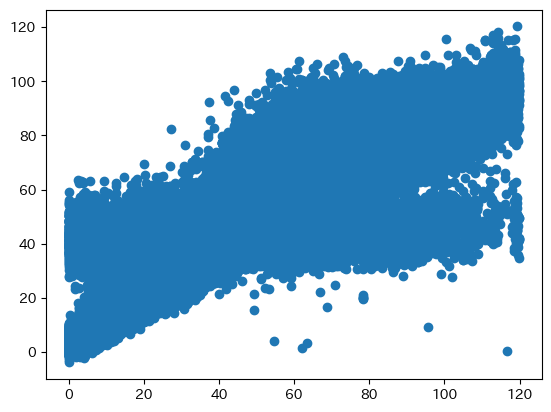

In [173]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

In [171]:
X_prediction = df_test[config.features]
y_prediction = model.predict(X_prediction, num_iteration=model.best_iteration)
y_prediction

array([55.83802743, 17.79663374, 50.86193343, ...,  8.11966412,
       74.90796748, 56.69693459])

In [174]:
df_submit = da.get_submit_data()
df_submit.columns = df_submit.iloc[0]
df_submit = df_submit.iloc[1:].reset_index(drop=True)

df_submit["Listening_Time_minutes"] = y_prediction
df_submit.to_csv(f'submit_{config.exp_name}.csv', index=False)

In [175]:
ls ~/.kaggle

kaggle.json


In [176]:
!kaggle competitions submit -c playground-series-s5e4 -f submit_exp002.csv -m "Initial submission"

/Users/takizawakeiya/Desktop/python/Takizawa-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████████████████████████████████| 6.01M/6.01M [00:01<00:00, 3.30MB/s]
Successfully submitted to Predict Podcast Listening Time